In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


DB_PATH = '/Users/beans/Desktop/TeamHousing/data/processed/nyc_demolitions.db'
HOUSING_PATH = '/Users/beans/Desktop/TeamHousing/data/HousingDB_post2010.csv'
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

queryowner_demo = """
SELECT *
FROM fact_demolitions f
WHERE month_date BETWEEN '2016-01-01' AND '2023-01-01'
"""

fact_owner_demo = pd.read_sql_query(queryowner_demo, conn)

queryshelter = """
SELECT *
FROM fact_shelters
WHERE report_date BETWEEN '2016-01-01' AND '2023-01-01'
"""
fact_shelter = pd.read_sql_query(queryshelter, conn)

display(fact_owner_demo.sort_values(by=['bin'],ascending=False).head())
display(fact_shelter.sort_values(by=['report_date'],ascending=False).head())

# setting job_typeid to strings to represent what the job done is
mapdemo = {1:'construction',2:'demolition'}
fact_owner_demo['job_typeid'] = fact_owner_demo['job_typeid'].map(mapdemo)

# setting ownership_id 1 to private and 2/3 to affordable (government & nonprofit)
mapowner = {1:'private',2:'affordable',3:'affordable'}
fact_owner_demo['ownership_id'] = fact_owner_demo['ownership_id'].map(mapowner)


,month_date,bin,job_typeid,ownership_id,borough,date_filed,date_completed,time_of_completion
10466,2018-08-01 00:00:00,5867189,2,1,Staten Island,2018-06-21 00:00:00,2018-08-03 00:00:00,43
10464,2018-09-01 00:00:00,5867187,2,1,Staten Island,2018-06-21 00:00:00,2018-09-24 00:00:00,95
10463,2018-11-01 00:00:00,5867186,2,1,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158
10462,2018-11-01 00:00:00,5867185,2,1,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158
10621,2017-10-01 00:00:00,5866758,2,1,Staten Island,2017-09-28 00:00:00,2017-10-31 00:00:00,33


,report_date,shelter_count
0,2022-12-01 00:00:00,44958
1,2022-11-01 00:00:00,42338
2,2022-10-01 00:00:00,41852
3,2022-09-01 00:00:00,39541
4,2022-08-01 00:00:00,35811


In [3]:
shelter = fact_shelter.copy()

shelter['report_date'] = pd.to_datetime(shelter['report_date'])

#shelter has some duplicate dates
shelter['report_date'].value_counts()
shelter = shelter.drop_duplicates(subset=['report_date'])

# renaming to be able to merge
shelter= shelter.rename(mapper={'report_date':'month_date'},axis=1)

shelter = shelter.sort_values(by='month_date',ascending=True)


s = shelter.set_index(shelter['month_date'])['shelter_count'].asfreq('MS')

In [4]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(s)
print(f"p value is: {adf_result[1]:.10f}")

# p value is less than 0.05, indicating stationarity

p value is: 0.0008886791


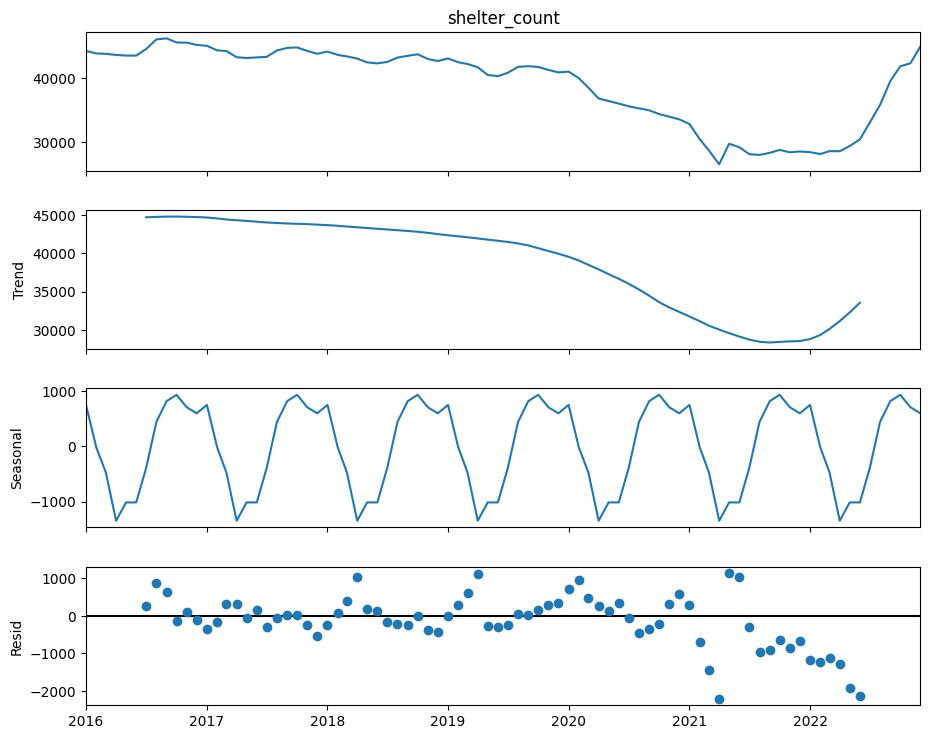

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose the time series (assuming a 12-month cycle)
decomp = seasonal_decompose(s, model='additive', period=12)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.show()

# dip between 2021 and 2022, raises through 2022 to 2023

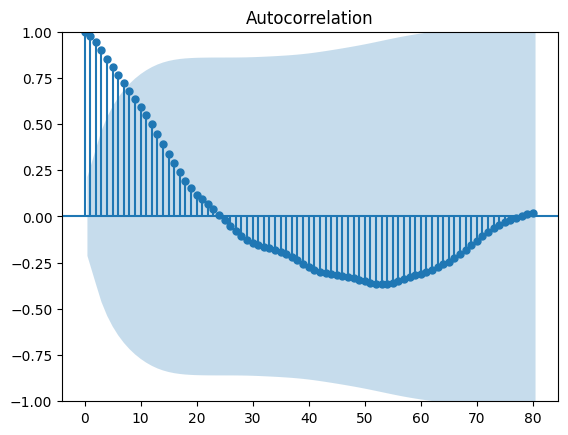

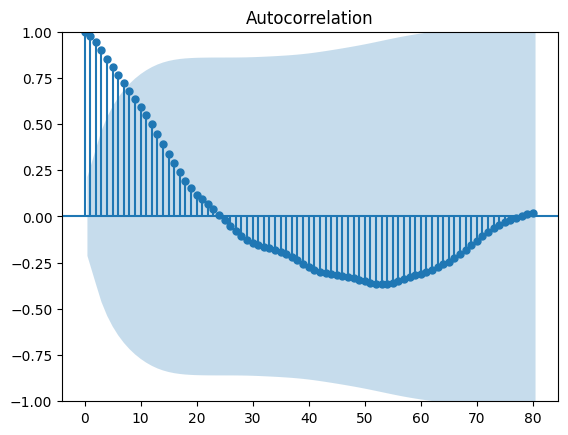

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#shows moving average for time series lags
plot_acf(s, lags=80)

# picking MA to be 7 as our plot shows this is when 

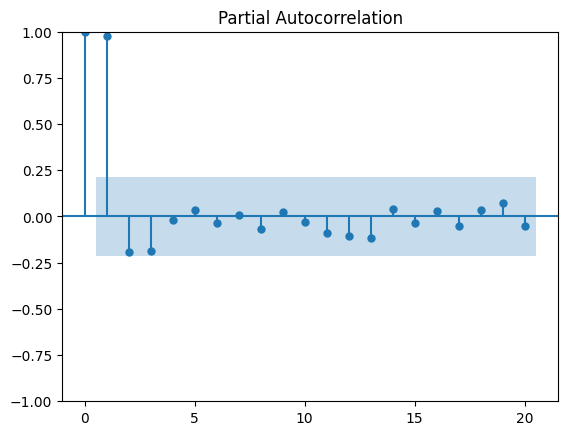

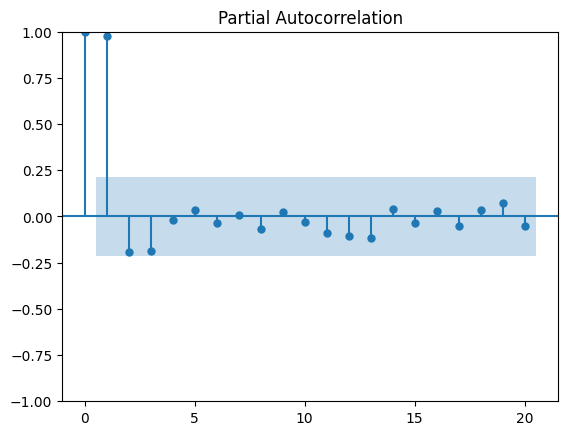

In [7]:
plot_pacf(s)

#peaks at 1, each previous lag has a significant impact on the next value

# BASELINE MONTHLY

In [8]:
# train test splits
splitbaseline = int(len(s) * 0.80)
# 80% of the data
trainbaseline = s.iloc[:splitbaseline]
# 20% of the data
testbaseline  = s.iloc[splitbaseline:]


Baseline RMSE: 1,599.587


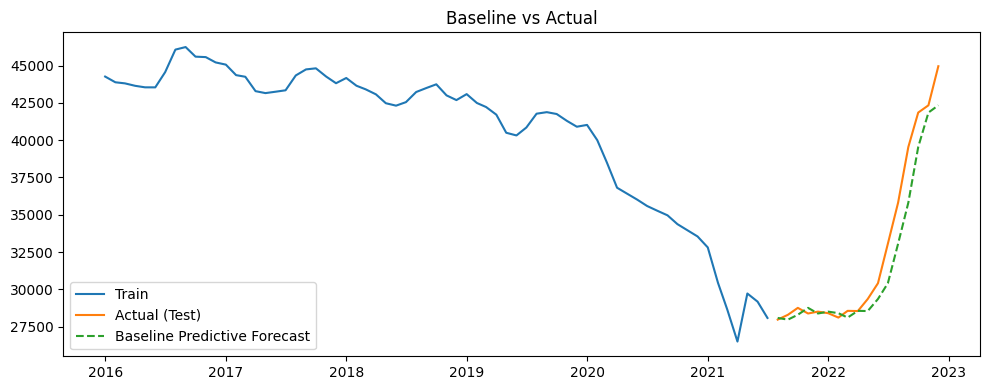

In [9]:
# baseline prediction is using the previous value as the way to predict the next value
predict = s.shift(1)[testbaseline.index]
rmse_baseline = np.sqrt(mean_squared_error(testbaseline,predict))


print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainbaseline, label="Train")
plt.plot(testbaseline, label="Actual (Test)", color="#ff7f0e")
plt.plot(predict, label="Baseline Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title('Baseline vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


# ARIMA (MONTHLY)

In [10]:
# train test splits
splitarima = int(len(s) * 0.80)
# 80% of the data
trainarima = s.iloc[:splitarima]
# 20% of the data
testarima  = s.iloc[splitarima:]

In [11]:
from statsmodels.tsa.arima.model import ARIMA

arimamodel = ARIMA(trainarima, order=(1, 0, 7))
arimamodel_fit = arimamodel.fit()

# --- 3. Make Predictions ---
# Forecast the next 12 periods
predictionarima = arimamodel_fit.forecast(steps=len(testarima))

arimamodel_fit.summary()

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          shelter_count   No. Observations:                   67
Model:                 ARIMA(1, 0, 7)   Log Likelihood                -543.925
Date:                Thu, 19 Feb 2026   AIC                           1107.851
Time:                        16:34:15   BIC                           1129.898
Sample:                    01-01-2016   HQIC                          1116.575
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.064e+04   5822.353      6.981      0.000    2.92e+04    5.21e+04
ar.L1          0.9211      0.097      9.523      0.000       0.731       1.111
ma.L1          0.3129      0.771      0.406      0.685      -1.198       1.823
ma.L2          0.3025      0.344      0.880      0.379      -0.372       0.977
ma.L3          0.2263      0.669      0.338      0.735      -1.085       1.538
ma.L4          0.3833      1.351      0.284      0.777      -2.264       3.030
ma.L5          0.7120      1.195      0.596      0.551      -1.631       3.055
ma.L6          0.3422      0.543      0.631      0.528      -0.721       1.406
ma.L7         -0.2079      0.430     -0.484      0.628      -1.050       0.634
sigma2      7.631e+05   9.55e+05      0.799      0.424   -1.11e+06    2.63e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               103.62
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               4.12   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.96e+14. Standard errors may be unstable.
"""

Arima (1,0,7) RMSE: 4,415.159


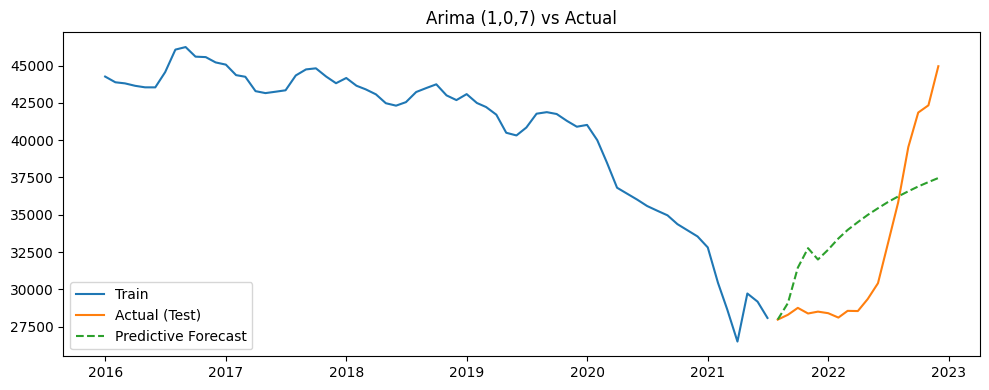

In [12]:
arima_rmse = np.sqrt(mean_squared_error(testarima, predictionarima))

print(f"Arima (1,0,7) RMSE: {arima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainarima, label="Train")
plt.plot(testarima, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictionarima, label="Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("Arima (1,0,7) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMA (monthly)

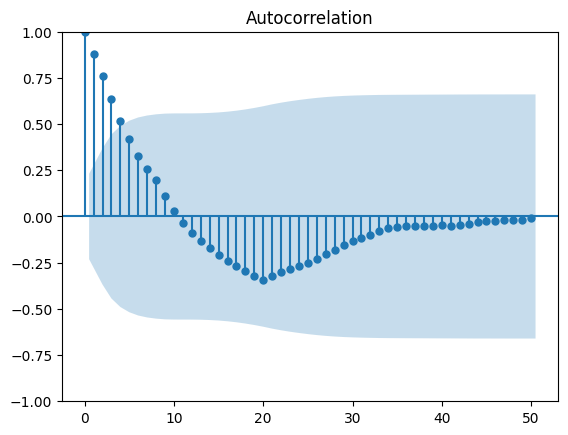

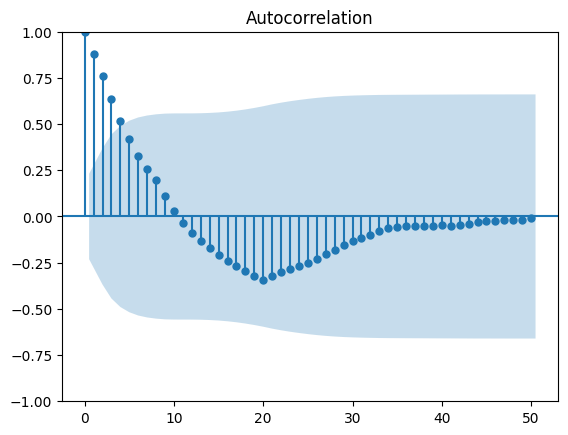

In [13]:
# differencing data (D = 12) to find if any seasonal attribute/ P and Q for SARIMA
diff_s = s.diff(12).dropna()

plot_acf(diff_s, lags=50)

# we see the seasonal component is within the confidence interval, meaning that it is not statistically significant after differencing
# Q seems to be 4, right before falling into confidence interval (is statistically significant)

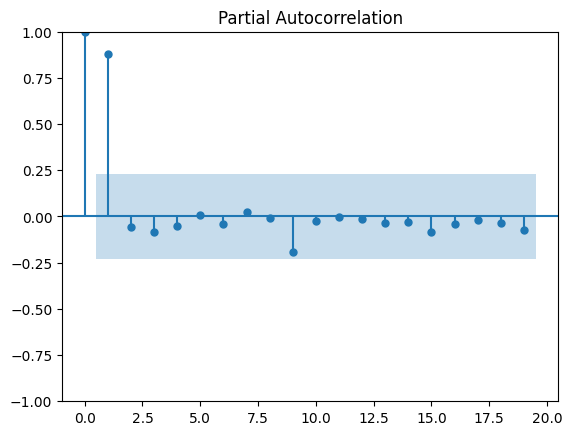

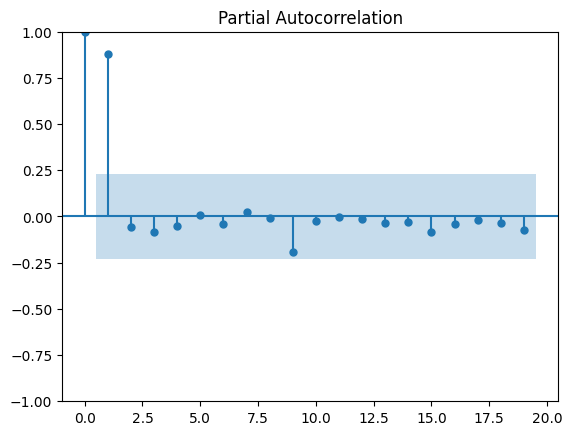

In [14]:
plot_pacf(diff_s)
# P is one, spike on first

In [15]:
# train test splits
splitSarima = int(len(s) * 0.80)
# 80% of the data
trainSarima = s.iloc[:splitSarima]
# 20% of the data
testSarima  = s.iloc[splitSarima:]

In [16]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
modelSarima = SARIMAX(
    trainSarima,
    order=(1, 0, 7),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 4, 12),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
Sarimamodel_fit = modelSarima.fit()

Sarimamodel_fit.summary()

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return se

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                 shelter_count   No. Observations:                   67
Model:             SARIMAX(1, 0, 7)x(1, 1, [1, 2, 3, 4], 12)   Log Likelihood                   0.000
Date:                                       Thu, 19 Feb 2026   AIC                             28.000
Time:                                               16:34:16   BIC                                nan
Sample:                                           01-01-2016   HQIC                               nan
                                                - 07-01-2021                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9777         -0       -inf      0.000       0.978       0.978
ma.L1          0.1280         -0       -inf      0.000       0.128       0.128
ma.L2         -0.0773         -0        inf      0.000      -0.077      -0.077
ma.L3          0.3733         -0       -inf      0.000       0.373       0.373
ma.L4          0.0113         -0       -inf      0.000       0.011       0.011
ma.L5          0.2261         -0       -inf      0.000       0.226       0.226
ma.L6          0.2094         -0       -inf      0.000       0.209       0.209
ma.L7          0.1873         -0       -inf      0.000       0.187       0.187
ar.S.L12            0         -0        nan        nan           0           0
ma.S.L12            0         -0        nan        nan           0           0
ma.S.L24            0         -0        nan        nan           0           0
ma.S.L36            0         -0        nan        nan           0           0
ma.S.L48            0         -0        nan        nan           0           0
sigma2      7.905e+05         -0       -inf      0.000    7.91e+05    7.91e+05
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Sarima (1,0,7) RMSE: 9,210.718


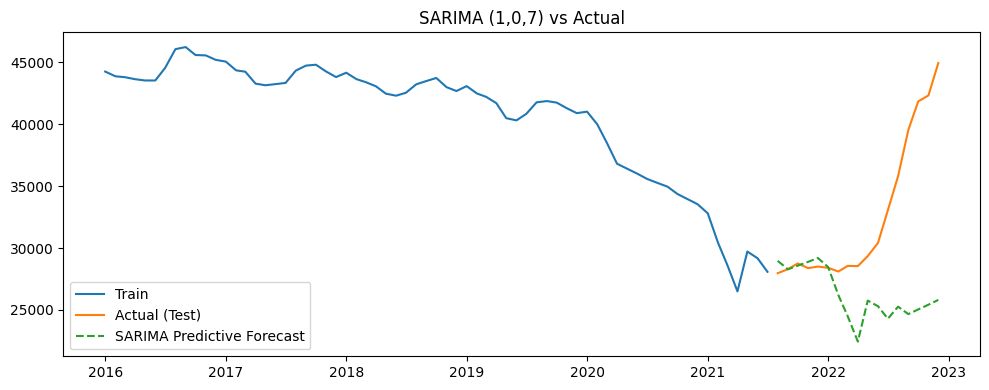

In [17]:
predictionSarima = Sarimamodel_fit.forecast(steps=len(testSarima))
sarima_rmse = np.sqrt(mean_squared_error(testSarima, predictionSarima))

print(f"Sarima (1,0,7) RMSE: {sarima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainSarima, label="Train")
plt.plot(testSarima, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictionSarima, label="SARIMA Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("SARIMA (1,0,7) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMAX (monthly)

In [18]:
sarimaXdata = fact_owner_demo.copy()

# copying data, subsetting to only have these columns
sarimaXdata = sarimaXdata[['month_date','job_typeid','ownership_id']]
# filtering to be only affordable demolitions
sarimaXdata = sarimaXdata[(sarimaXdata['ownership_id'] == 'affordable') & (sarimaXdata['job_typeid'] == 'demolition')]

# making data chronological
sarimaXdata.sort_values(by='month_date',ascending=False)
sarimaXdata['month_date'] = pd.to_datetime(sarimaXdata['month_date'])

# grouping by month_date to count amount of demolitions
sarimaxdata = sarimaXdata.groupby('month_date').agg({'job_typeid':'count'})

# create an empty df to merge with original data and have all months (even ones with 0 demolitions)
empty = pd.date_range(start='2016-01-01',end='2022-12-01',freq='MS')
datedf = pd.DataFrame(data=empty)

datedf = datedf.rename(mapper={0:'month_date'},axis=1)
# merging with sarimax_data
datedf = datedf.merge(sarimaxdata,how='left',on='month_date')
datedf = datedf.fillna(0)

# complete merge of dates, counts of affordable demolitions and shelter counts
datedf = datedf.merge(shelter,how='left',on='month_date')

# having months be index for our SARIMAX model
#datedf.set_index(keys='month_date')

datedf = datedf.rename(mapper={'job_typeid':'affordable_demo'},axis=1)
prophetf = datedf.copy()
datedf.set_index("month_date",inplace=True)

# CHATGPT CODE TO ADD 'covid_dummy' AS A INTERACTION TERM TO ACCOUNT FOR COVID SPIKE (exog variable)
# Initialize COVID dummy as 0
datedf['covid_dummy'] = 0
# Set to 1 for months affected by COVID (March 2020 – December 2021)
datedf.loc['2020-03-01':'2021-12-01', 'covid_dummy'] = 1

# CHATGPT CODE TO THINK ABOUT HOW DEMO PROBABLY DOESN'T AFFECT SHELTER COUNT IMMEDIATELY (exog variable)
# assuming demolitions aren't giving an immediate impact, but a 1/2 month lag effect
datedf['aff_demo_lag1'] = datedf['affordable_demo'].shift(1).fillna(0)  # 1 month lag
datedf['aff_demo_lag2'] = datedf['affordable_demo'].shift(2).fillna(0)  # 2 month lag

datedf

,affordable_demo,shelter_count,covid_dummy,aff_demo_lag1,aff_demo_lag2
month_date,,,,,
2016-01-01,4.0,44265,0,0.0,0.0
2016-02-01,4.0,43882,0,4.0,0.0
2016-03-01,4.0,43809,0,4.0,4.0
2016-04-01,6.0,43645,0,4.0,4.0
2016-05-01,4.0,43543,0,6.0,4.0
...,...,...,...,...,...
2022-08-01,1.0,35811,0,0.0,0.0
2022-09-01,2.0,39541,0,1.0,0.0
2022-10-01,2.0,41852,0,2.0,1.0


In [19]:
# train test splits (including exogenous variable)
splitSarimaX = int(len(s) * 0.80)
# 80% of the data
trainSarimax = datedf['shelter_count'].iloc[:splitSarimaX]
trainexogSarimax = datedf[['aff_demo_lag1','covid_dummy']].iloc[:splitSarimaX]
# 30% of the data
testSarimax  = datedf['shelter_count'].iloc[splitSarimaX:]
testexogx = datedf[['aff_demo_lag1','covid_dummy']].iloc[splitSarimaX:]

In [20]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
# same as SARIMA, except include endog variable
modelSarimax = SARIMAX(
    trainSarimax,
    # exog variable is ['affordable_demo'] column
    exog=trainexogSarimax,
    order=(1, 0, 7),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 4, 12),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultsSarimax = modelSarimax.fit()

resultsSarimax.summary()
# covid_dummy was able to recognize the drop in shelter count, doesn't really understand spike as it is not in training data
# affordable_demo : -54.1314 coef
# aff_demo_lag1 : 40.1006 coef
# aff_demo_lag2 : 38.2014 coef

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: inval

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                 shelter_count   No. Observations:                   67
Model:             SARIMAX(1, 0, 7)x(1, 1, [1, 2, 3, 4], 12)   Log Likelihood                   0.000
Date:                                       Thu, 19 Feb 2026   AIC                             32.000
Time:                                               16:34:17   BIC                                nan
Sample:                                           01-01-2016   HQIC                               nan
                                                - 07-01-2021                                         
Covariance Type:                                         opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
aff_demo_lag1    12.2075         -0       -inf      0.000      12.207      12.207
covid_dummy   -6307.5581         -0        inf      0.000   -6307.558   -6307.558
ar.L1             0.9622         -0       -inf      0.000       0.962       0.962
ma.L1            -0.1792         -0        inf      0.000      -0.179      -0.179
ma.L2            -0.0120         -0        inf      0.000      -0.012      -0.012
ma.L3             0.0838         -0       -inf      0.000       0.084       0.084
ma.L4             0.0635         -0       -inf      0.000       0.063       0.063
ma.L5            -0.1905         -0        inf      0.000      -0.190      -0.190
ma.L6             0.0006         -0       -inf      0.000       0.001       0.001
ma.L7             0.0220         -0       -inf      0.000       0.022       0.022
ar.S.L12               0         -0        nan        nan           0           0
ma.S.L12               0         -0        nan        nan           0           0
ma.S.L24               0         -0        nan        nan           0           0
ma.S.L36               0         -0        nan        nan           0           0
ma.S.L48               0         -0        nan        nan           0           0
sigma2         3.284e+06         -0       -inf      0.000    3.28e+06    3.28e+06
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Sarimax (1,1,4,12) RMSE: 5,555.262


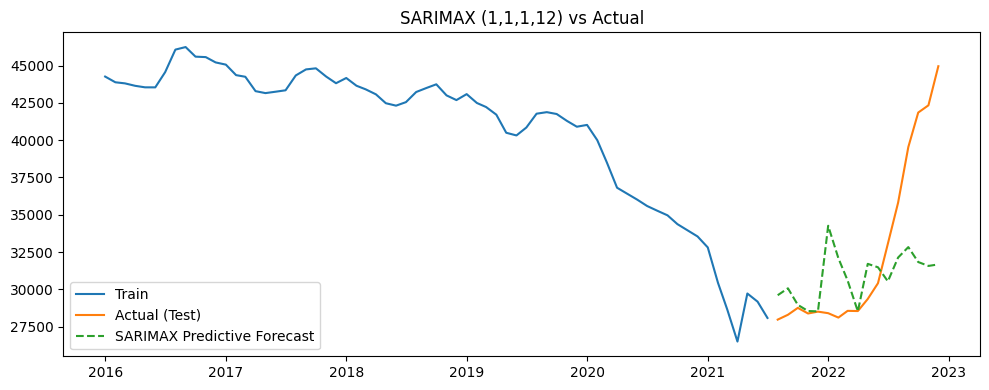

In [21]:
predx = resultsSarimax.get_forecast(steps=len(testSarimax),exog=testexogx)
predictionsx = predx.predicted_mean
sarima_rmsex = np.sqrt(mean_squared_error(testSarimax, predictionsx))

print(f"Sarimax (1,1,4,12) RMSE: {sarima_rmsex:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainSarimax, label="Train")
plt.plot(testSarimax, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictionsx, label="SARIMAX Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("SARIMAX (1,1,1,12) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

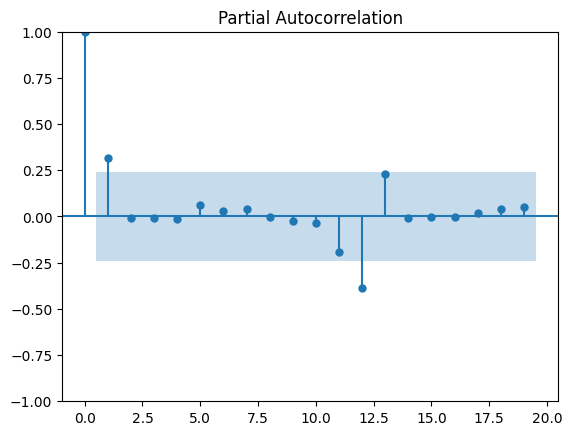

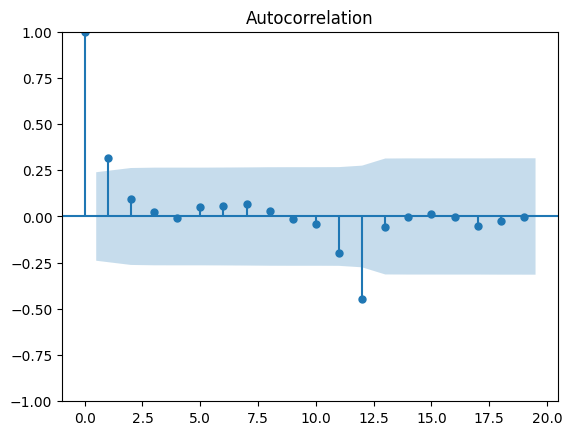

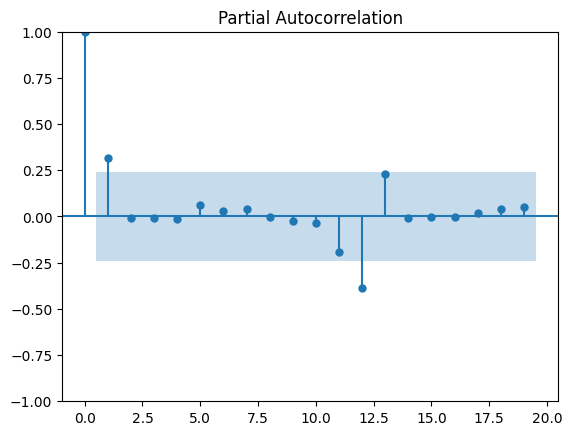

In [22]:
#plotting residuals to see if any spikes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(resultsSarimax.resid)
plot_pacf(resultsSarimax.resid)

# spike at 1 and 12 for both, spike at 12 means some seasonal patterns are unexplained
# increasing P or Q increases the spike at lag 12, so reason is due to irregular events (covid)

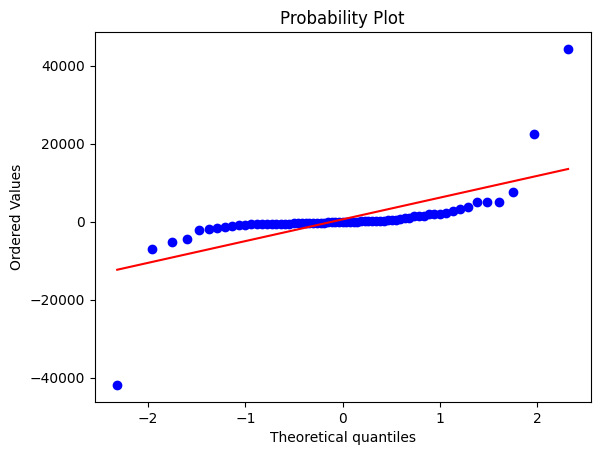

In [23]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# qq plot
stats.probplot(resultsSarimax.resid, dist="norm", plot=plt)
plt.show()


# roughly normal residuals 

# CHECKING QUARTERLY

In [24]:
# resampling for quarterly, looking to see if diff in trends
qs = s.resample('Q').sum()

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_8896/1649285509.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  qs = s.resample('Q').sum()


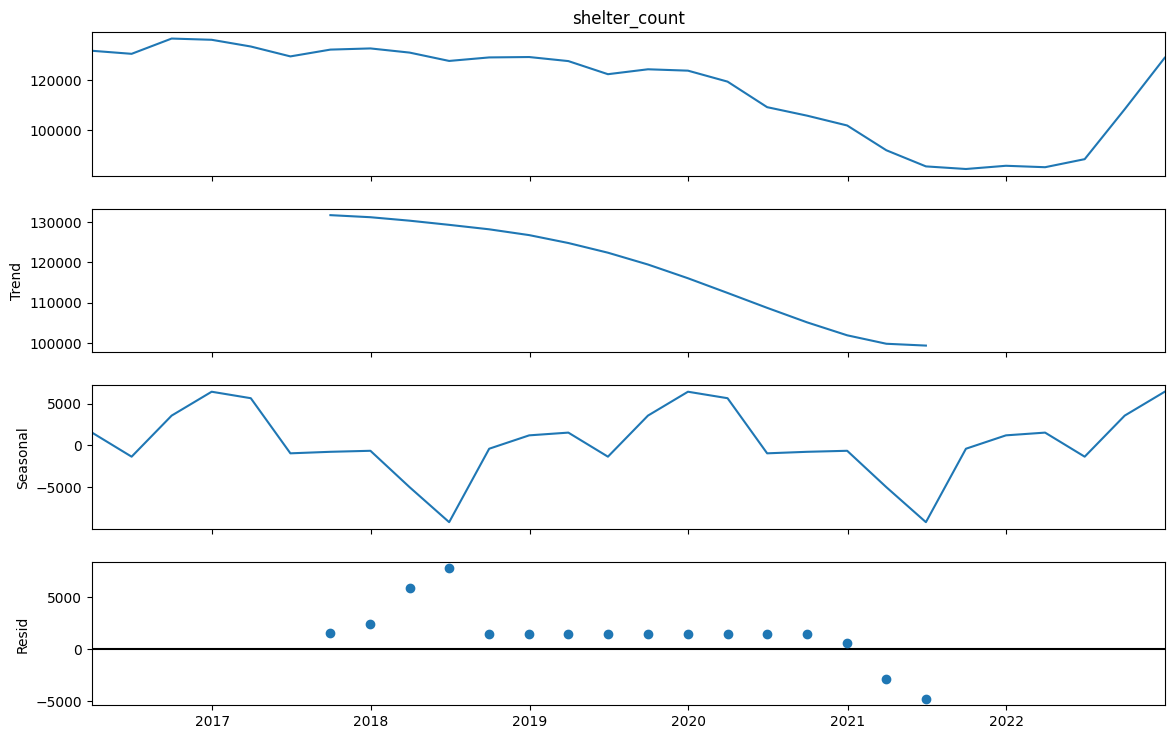

In [25]:
# decompose the time series (assuming a 12-month cycle)
decomp = seasonal_decompose(qs, model='additive', period=12)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(13, 8)
plt.show()

# dip between 2021 and 2022, raises through 2022 to 2023

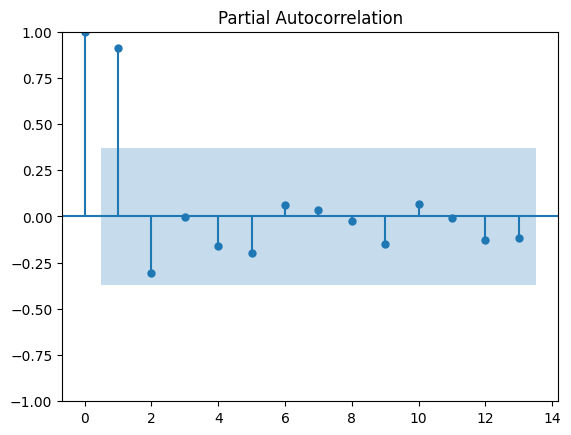

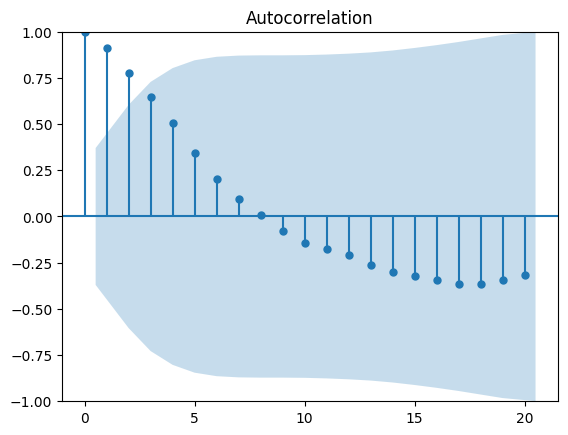

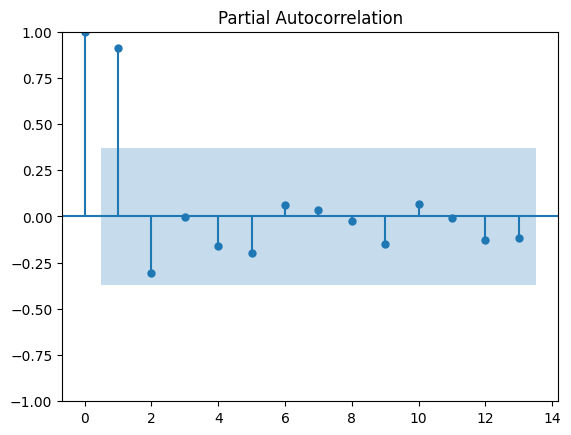

In [26]:
plot_acf(qs, lags=20)
plot_pacf(qs, lags=13)

In [27]:
# QUARTERLY
# train test splits
qsplitbaseline = int(len(qs) * 0.80)
# 80% of the data
qtrainbaseline = qs.iloc[:qsplitbaseline]
# 20% of the data
qtestbaseline  = qs.iloc[qsplitbaseline:]

Baseline RMSE: 11,885.480


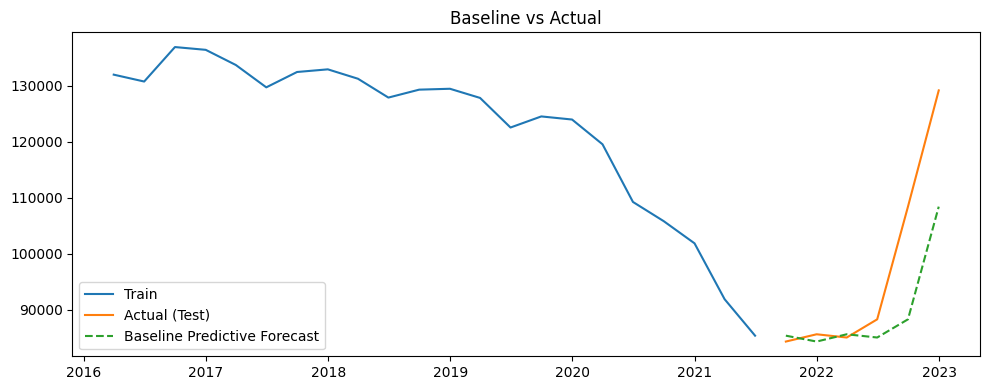

In [28]:
# baseline prediction is using the previous value as the way to predict the next value
qpredict = qs.shift(1)[qtestbaseline.index]
qrmse_baseline = np.sqrt(mean_squared_error(qtestbaseline,qpredict))


print(f"Baseline RMSE: {qrmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(qtrainbaseline, label="Train")
plt.plot(qtestbaseline, label="Actual (Test)", color="#ff7f0e")
plt.plot(qpredict, label="Baseline Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title('Baseline vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


# Q ARIMA

In [29]:
# train test splits
qsplitarima = int(len(qs) * 0.80)
# 80% of the data
qtrainarima = qs.iloc[:qsplitarima]
# 20% of the data
qtestarima  = qs.iloc[qsplitarima:]

In [30]:
from statsmodels.tsa.arima.model import ARIMA

qarimamodel = ARIMA(qtrainarima, order=(1, 0, 2))
qarimamodel_fit = qarimamodel.fit()

# --- 3. Make Predictions ---
# Forecast the next 12 periods
qpredictionarima = qarimamodel_fit.forecast(steps=len(qtestarima))

qarimamodel_fit.summary()

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          shelter_count   No. Observations:                   22
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -213.211
Date:                Thu, 19 Feb 2026   AIC                            436.423
Time:                        16:34:21   BIC                            441.878
Sample:                    03-31-2016   HQIC                           437.708
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.225e+05   1.25e+04      9.803      0.000     9.8e+04    1.47e+05
ar.L1          0.8293      0.180      4.616      0.000       0.477       1.181
ma.L1          1.2230      0.418      2.928      0.003       0.404       2.042
ma.L2          0.9991      0.411      2.430      0.015       0.193       1.805
sigma2      1.042e+07      0.000   1.03e+11      0.000    1.04e+07    1.04e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.46   Prob(JB):                         0.94
Heteroskedasticity (H):               2.02   Skew:                            -0.17
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+32. Standard errors may be unstable.
"""

Arima (1,0,7) RMSE: 12,686.645


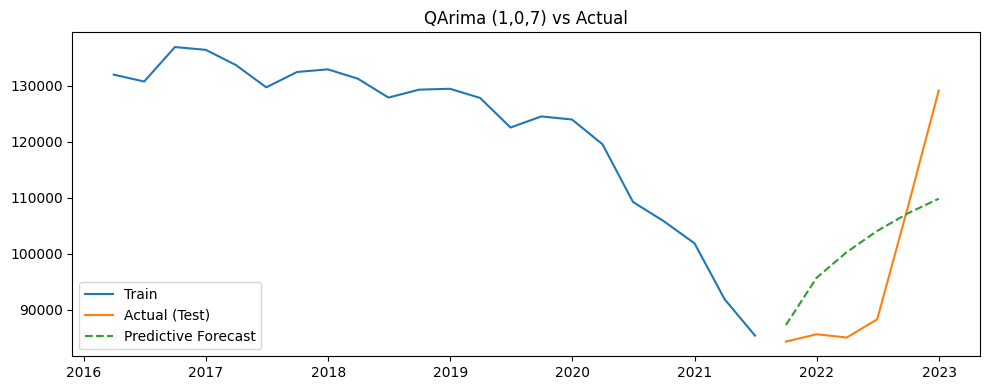

In [31]:
qarima_rmse = np.sqrt(mean_squared_error(qtestarima, qpredictionarima))

print(f"Arima (1,0,7) RMSE: {qarima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(qtrainarima, label="Train")
plt.plot(qtestarima, label="Actual (Test)", color="#ff7f0e")
plt.plot(qpredictionarima, label="Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("QArima (1,0,7) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# QSARIMA

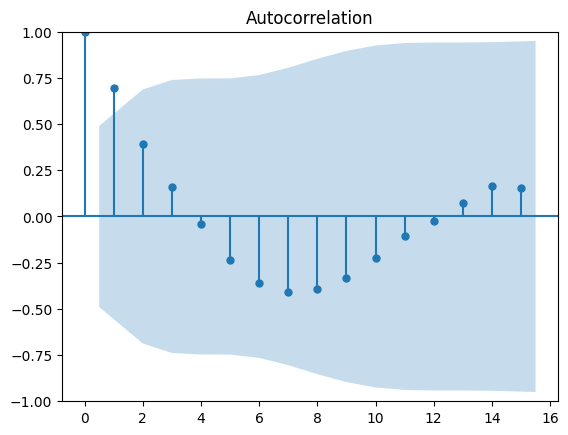

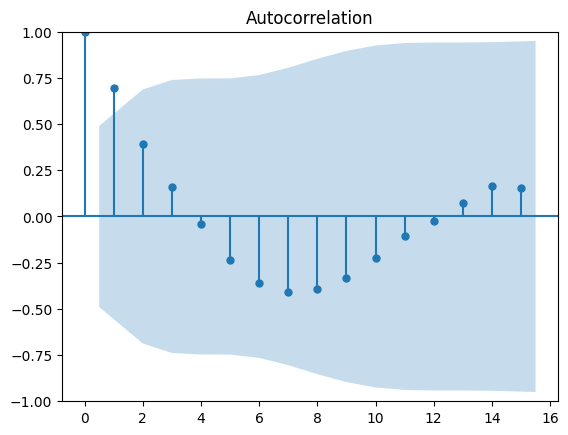

In [32]:
# differencing data (D = 12) to find if any seasonal attribute/ P and Q for SARIMA
qdiff_s = qs.diff(12).dropna()

plot_acf(qdiff_s, lags=15)

# we see the seasonal component is within the confidence interval, meaning that it is not statistically significant after differencing
# Q seems to be 4, right before falling into confidence interval (is statistically significant)

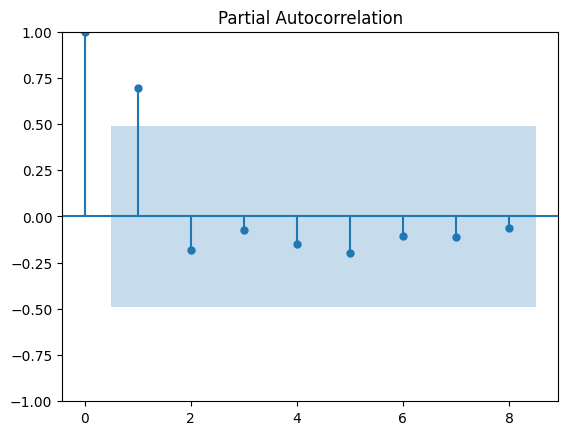

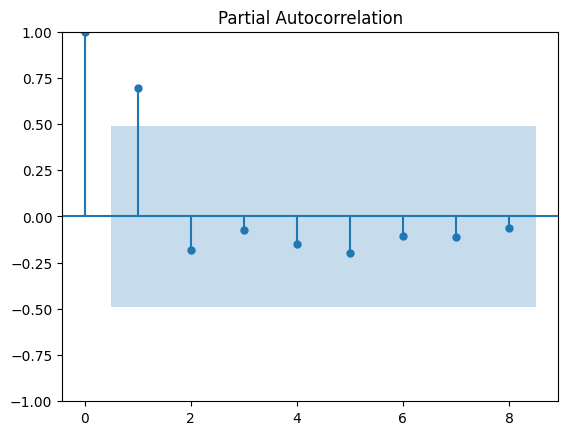

In [33]:
plot_pacf(qdiff_s)
# P is one, spike on first

In [34]:
# train test splits
qsplitSarima = int(len(qs) * 0.80)
# 80% of the data
qtrainSarima = qs.iloc[:qsplitSarima]
# 20% of the data
qtestSarima  = qs.iloc[qsplitSarima:]

In [35]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
qmodelSarima = SARIMAX(
    qtrainSarima,
    order=(1, 0, 1),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 1, 4),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
qSarimamodel_fit = qmodelSarima.fit()

qSarimamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     shelter_count   No. Observations:                   22
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 4)   Log Likelihood                -111.692
Date:                           Thu, 19 Feb 2026   AIC                            233.384
Time:                                   16:34:22   BIC                            235.809
Sample:                               03-31-2016   HQIC                           232.486
                                    - 06-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1644      0.096     12.179      0.000       0.977       1.352
ma.L1         -0.0006      0.734     -0.001      0.999      -1.439       1.437
ar.S.L4       -0.7291      0.744     -0.980      0.327      -2.188       0.729
ma.S.L4       -0.0183      0.250     -0.073      0.942      -0.508       0.471
sigma2      7.256e+06    9.7e-09   7.48e+14      0.000    7.26e+06    7.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                 1.41
Prob(Q):                              0.53   Prob(JB):                         0.49
Heteroskedasticity (H):               3.30   Skew:                             0.76
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+32. Standard errors may be unstable.
"""

Sarima (1,0,7) RMSE: 62,930.689


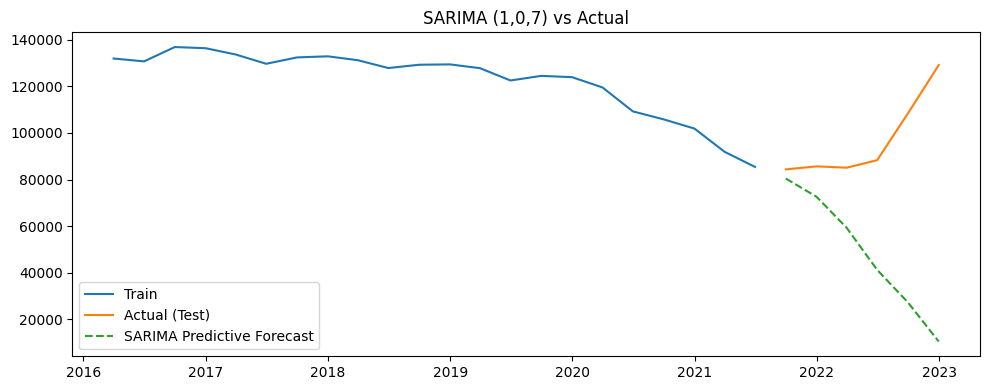

In [36]:
qpredictionSarima = qSarimamodel_fit.forecast(steps=len(qtestSarima))
qsarima_rmse = np.sqrt(mean_squared_error(qtestSarima, qpredictionSarima))

print(f"Sarima (1,0,7) RMSE: {qsarima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(qtrainSarima, label="Train")
plt.plot(qtestSarima, label="Actual (Test)", color="#ff7f0e")
plt.plot(qpredictionSarima, label="SARIMA Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("SARIMA (1,0,7) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# Q SARIMAX

In [37]:
qdatedf = datedf.resample('Q').sum()

qdatedf['covid_dummy'] = 0
# Set to 1 for months affected by COVID (March 2020 – December 2021)
qdatedf.loc['2020-03-01':'2021-12-01', 'covid_dummy'] = 1

# CHATGPT CODE TO THINK ABOUT HOW DEMO PROBABLY DOESN'T AFFECT SHELTER COUNT IMMEDIATELY (exog variable)
# assuming demolitions aren't giving an immediate impact, but a 1/2 month lag effect
qdatedf['aff_demo_lag1'] = qdatedf['affordable_demo'].shift(1).fillna(0)  # 1 month lag
qdatedf['aff_demo_lag2'] = qdatedf['affordable_demo'].shift(2).fillna(0)  # 2 month lag

qdatedf

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_8896/3411043575.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  qdatedf = datedf.resample('Q').sum()


,affordable_demo,shelter_count,covid_dummy,aff_demo_lag1,aff_demo_lag2
month_date,,,,,
2016-03-31,12.0,131956,0,0.0,0.0
2016-06-30,15.0,130729,0,12.0,0.0
2016-09-30,15.0,136877,0,15.0,12.0
2016-12-31,12.0,136382,0,15.0,15.0
2017-03-31,12.0,133677,0,12.0,15.0
2017-06-30,9.0,129693,0,12.0,12.0
2017-09-30,8.0,132430,0,9.0,12.0
2017-12-31,3.0,132902,0,8.0,9.0
2018-03-31,9.0,131227,0,3.0,8.0


In [38]:
# train test splits (including exogenous variable)
qsplitSarimaX = int(len(qs) * 0.80)
# 80% of the data
qtrainSarimax = qdatedf['shelter_count'].iloc[:qsplitSarimaX]
qtrainexogSarimax = qdatedf[['aff_demo_lag1','covid_dummy']].iloc[:qsplitSarimaX]
# 30% of the data
qtestSarimax  = qdatedf['shelter_count'].iloc[qsplitSarimaX:]
qtestexogx = qdatedf[['aff_demo_lag1','covid_dummy']].iloc[qsplitSarimaX:]

In [39]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
# same as SARIMA, except include endog variable
qmodelSarimax = SARIMAX(
    qtrainSarimax,
    # exog variable is ['affordable_demo'] column
    exog=qtrainexogSarimax,
    order=(1, 0, 1),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 1, 4),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
qresultsSarimax = qmodelSarimax.fit()

qresultsSarimax.summary()
# covid_dummy was able to recognize the drop in shelter count, doesn't really understand spike as it is not in training data
# affordable_demo : -54.1314 coef
# aff_demo_lag1 : 40.1006 coef
# aff_demo_lag2 : 38.2014 coef

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     shelter_count   No. Observations:                   22
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 4)   Log Likelihood                -122.117
Date:                           Thu, 19 Feb 2026   AIC                            258.233
Time:                                   16:34:22   BIC                            261.628
Sample:                               03-31-2016   HQIC                           256.976
                                    - 06-30-2021                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
aff_demo_lag1   521.3009   1291.908      0.404      0.687   -2010.793    3053.394
covid_dummy   -1.923e+04   1.54e+04     -1.245      0.213   -4.95e+04     1.1e+04
ar.L1             1.0090      1.473      0.685      0.493      -1.878       3.896
ma.L1            -0.1002      0.909     -0.110      0.912      -1.881       1.681
ar.S.L4          -1.3244      2.645     -0.501      0.617      -6.508       3.860
ma.S.L4          -0.0052      1.367     -0.004      0.997      -2.685       2.674
sigma2           6.9e+07      1.677   4.11e+07      0.000     6.9e+07     6.9e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):                13.88
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               8.69   Skew:                             1.91
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+24. Standard errors may be unstable.
"""

Sarimax (1,1,4,12) RMSE: 25,833.333


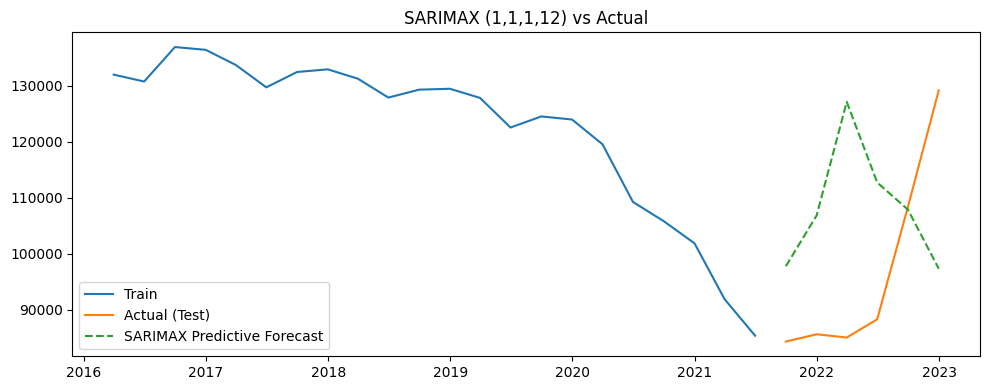

In [40]:
qpredx = qresultsSarimax.get_forecast(steps=len(qtestSarimax),exog=qtestexogx)
qpredictionsx = qpredx.predicted_mean
qsarima_rmsex = np.sqrt(mean_squared_error(qtestSarimax, qpredictionsx))

print(f"Sarimax (1,1,4,12) RMSE: {qsarima_rmsex:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(qtrainSarimax, label="Train")
plt.plot(qtestSarimax, label="Actual (Test)", color="#ff7f0e")
plt.plot(qpredictionsx, label="SARIMAX Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("SARIMAX (1,1,1,12) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# diagnostic

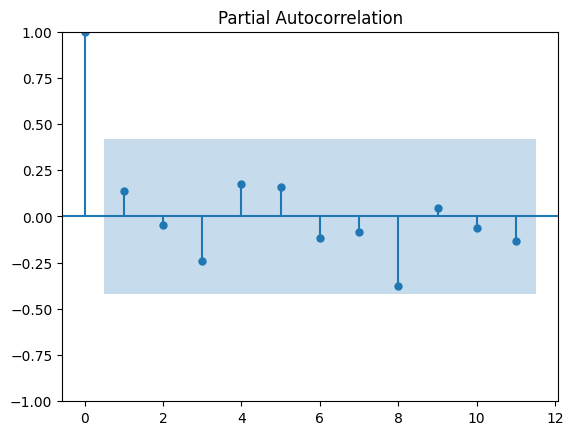

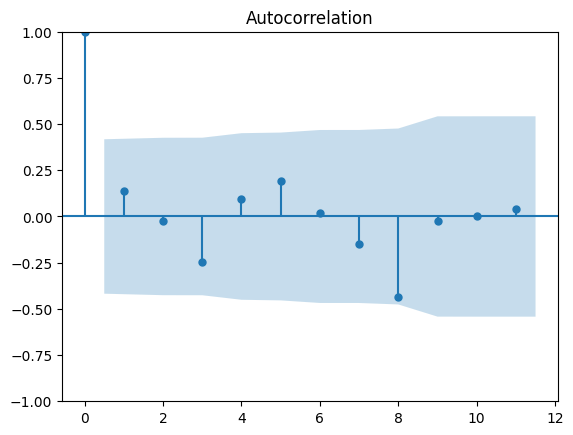

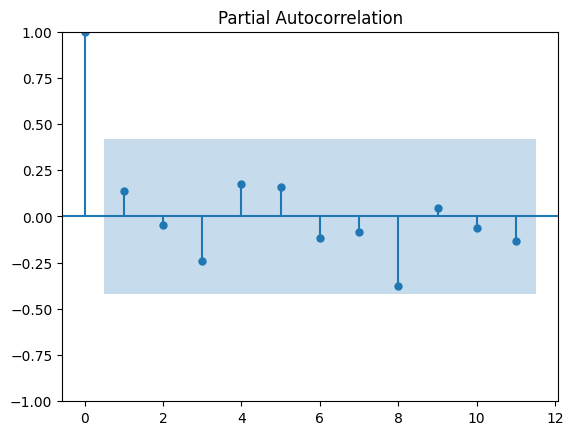

In [41]:
#plotting residuals to see if any spikes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(qresultsSarimax.resid)
plot_pacf(qresultsSarimax.resid)

# spike at 1 and 12 for both, spike at 12 means some seasonal patterns are unexplained
# increasing P or Q increases the spike at lag 12, so reason is due to irregular events (covid)